# Getting Started | U-Net with OpenPack Dataset (IMU)

## [0] Inital Setup

### 0-1: Download Requirements

In [1]:
! echo "git clone XXXX"

git clone XXXX


### 0-2: Install Requirements

In [2]:
! echo pip install -r requirements.txt

pip install -r requirements.txt


### 0-3: Import Modules

In [3]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict

import hydra
import numpy as np
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf
from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)


sns.set("notebook", "whitegrid")

### 0-4: Setup Logger

In [4]:
def setup_root_logger(log_level=logging.INFO):
    log_format = "%(asctime)s | %(levelname)s | %(name)s | %(message)s"
    logger = logging.getLogger()
    
    # add the handlers to the logger
    ch = logging.StreamHandler()
    ch.setLevel(log_level)
    ch_formatter = logging.Formatter(log_format, "%Y-%m-%d %H:%M:%S")
    ch.setFormatter(ch_formatter)
    logger.addHandler(ch)
    
    logger.setLevel(log_level)
    return logger

In [5]:
_ = setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-05-27 23:33:43 | INFO | __main__ | info
2022-05-27 23:33:43 | WARNING | __main__ | warning


## [1] Load Config File

In [6]:
config_dir = Path("/content/openpack-torch/configs")
overrides = [
    "mode=train",
    "debug=false",
    "datarootdir=/content/data",
    "hydra/job_logging=custom",
    "hydra/hydra_logging=disabled"
]

with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
    cfg = compose(
        config_name="operation-segmentation-unet.yaml",
        overrides=overrides,
    )
print(OmegaConf.to_yaml(cfg))

datarootdir: /content/data
issue: I01-EXP1-V1
debug: false
mode: train
train:
  num_workers: 3
  batch_size: 32
  epochs: 200
  window: 1800
  optimizer:
    type: Adam
    lr: 0.001
    weight_decay: 0.0001
  debug:
    batch_size: 8
    epochs: 5
volume:
  logdir:
    rootdir: ${datarootdir}/log/${dataset.name}/${model.name}/${issue}
    model: ${volume.logdir.rootdir}/model.pth
    predict: ${volume.logdir.rootdir}/pred/U{user:0=4}-S{session:0=4}
    summary: ${volume.logdir.rootdir}/summary.csv
model:
  name: UNet
  depth: 5
dataset:
  name: openpack-acc
  volume:
    rootdir: ${datarootdir}/datasets/openpack/
  modality:
    imu:
      nodes:
      - atr01
      - atr02
      use_acc: true
      use_gyro: false
      use_quat: false
  split:
    train:
    - - 102
      - 100
    - - 102
      - 200
    - - 102
      - 300
    val:
    - - 102
      - 400
    test:
    - - 102
      - 500
    submission:
    - - 102
      - 500
  num_classes: 10



## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Override `optorch.data.OpenPackBaseDataModule` to use IMU dataset.

In [7]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self) -> Dict:
        imu_cfg = self.cfg.dataset.modality.imu
        kwargs = {
            "imu_nodes": imu_cfg.nodes,
            "use_acc": imu_cfg.use_acc,
            "use_gyro": imu_cfg.use_gyro,
            "use_quat": imu_cfg.use_quat,
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In [8]:
class UNetLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        imu_cfg = self.cfg.dataset.modality.imu
        num_nodes = len(imu_cfg.nodes)

        in_ch = 0
        if imu_cfg.use_acc:
            in_ch += num_nodes * 3
        if imu_cfg.use_gyro:
            in_ch += num_nodes * 3
        if imu_cfg.use_quat:
            in_ch += num_nodes * 4

        model = optorch.models.imu.UNet(
            in_ch,
            cfg.dataset.num_classes,
            depth=cfg.model.depth,
        )
        return model

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [9]:
device = torch.device("cuda")
logdir = Path.cwd()
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

2022-05-27 23:33:44 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmpguv2cwou
2022-05-27 23:33:44 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmpguv2cwou/_remote_module_non_sriptable.py


In [10]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (conv_blocks): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3,

### 3-2: Initialize Trainer

In [11]:
num_epoch = cfg.train.debug.epochs if cfg.debug else cfg.train.epochs

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [12]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-05-27 23:33:45 | INFO | __main__ | Start training for 200 epochs.
2022-05-27 23:33:46 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:33:46 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:33:46 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=132, num_sequence=3, submission=False)
2022-05-27 23:33:46 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f65cd200190>}
2022-05-27 23:33:46 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-05-27 23:33:46 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | UNet             | 11.5 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.5 M    Trai

### 3-4: Plot Training Curve

In [13]:
df = pd.concat([
    pd.DataFrame(plmodel.log["train"]),
    pd.DataFrame(plmodel.log["val"]),
],axis=1,)
df.index.name = "epoch"

In [14]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.201164,0.201873,2.316991,0.159837
1,1.984612,0.341857,2.314400,0.170586
2,1.902127,0.378414,2.300478,0.149744
3,1.795048,0.432723,2.268022,0.148429
4,1.751810,0.433389,2.190969,0.197494


Training Log

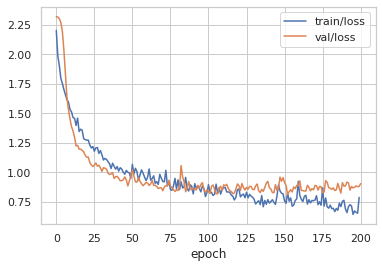

In [15]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

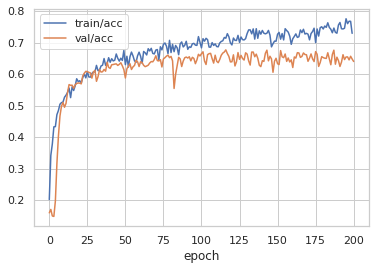

In [16]:
df[["train/acc", "val/acc"]].plot()
plt.show()

## [4] Test

### 4-1: Get prediction results for each sequences.

In [17]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on U{user:0=4}-S{session:0=4}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.volume.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"U{user:0=4}-S{session:0=4}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-05-27 23:37:34 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f66e9bff370>}
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-05-27 23:37:34 | INFO | __main__ | test on U0102-S0500
2022-05-27 23:37:34 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-05-27 23:37:34 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f65cce3b640>}
2022-05-27 23:37

### 4-2: Evaluate

In [18]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    outputs, OPENPACK_OPERATIONS,
)

In [19]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
12,avg/macro,-1,0.595952,0.577888,0.578461,None,all
13,avg/weighted,-1,0.599183,0.586319,0.583754,None,all
14,Picking,100,0.637931,0.443114,0.522968,167,all
15,MoveItemLabel,200,0.691824,0.571429,0.625889,385,all
16,AssembleBox,300,0.579646,0.505792,0.540206,259,all
17,PackInBox,400,0.456000,0.410072,0.431818,139,all
18,CloseBox,500,0.414414,0.508287,0.456576,181,all
19,ReadLabel,600,0.610687,0.816327,0.698690,294,all
20,AttachLabel,700,0.524887,0.738854,0.613757,157,all
21,PutOnCartRack,800,0.569767,0.612500,0.590361,80,all


## [5] Submission

### 5-1: Get prediction for test data.

In [20]:
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on U{user:0=4}-S{session:0=4}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.volume.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"U{user:0=4}-S{session:0=4}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-05-27 23:37:35 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[submission]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f66e9bffe80>}
2022-05-27 23:37:35 | INFO | __main__ | test on U0102-S0500
2022-05-27 23:37:35 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-05-27 23:37:35 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f65cd255d00>}
2022-05-27 23:37

### 5-2: Make submission zip file

In [21]:
output_dir = Path(".")

submission_dict = construct_submission_dict(
    outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)

2022-05-27 23:37:35 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.json to submission.json
2022-05-27 23:37:35 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.zip to submission.zip
